# Unitary cost function gradient descent

Created 03/10/2024

Objectives:
* For a given MPS, apply symmetry action and optimise for full unitary (i.e. not an MPO) at the boundary of the symmetry action. Then extract phase.
* When optimizing for the unitary and overlap costs, it's possible the optimal solution will not be unitary! How to resolve? Unitarity takes priority. But having a large unitarity step size can lead to divergences!
    * Could address this by performing unitarity gradient descent multiple times without overlap gradient descent when near optimum. Has effect of enhancing unitarity cost.

# Package imports

In [1]:
import sys
sys.path.append('../../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [188]:
import numpy as np
import matplotlib.pyplot as plt

import scipy

In [4]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import to_npc_array

In [5]:
import re

# Load data

In [6]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [7]:
f_name = DATA_DIR + r"/0_50.h5"

In [8]:
f_name

'../../data/transverse_cluster_200_site_dmrg/0_50.h5'

In [9]:
with h5py.File(f_name, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)
    test_psi = data['wavefunction']

# Definitions

In [10]:
NUM_SITES = 6

In [11]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [12]:
npc_I = to_npc_array(np_I)
npc_X = to_npc_array(np_X)
npc_Y = to_npc_array(np_Y)
npc_Z = to_npc_array(np_Z)

In [13]:
symmetry_actions = [
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [14]:
cases = [
    SymmetryActionWithBoundaryUnitaries(test_psi, a*50)
    for a in symmetry_actions
]

In [15]:
for c in cases:
    c.compute_svd_symmetry_action()

In [26]:
test_case = cases[1]

In [27]:
left_environment = test_case.right_projected_symmetry_state

In [30]:
bs = [
    test_case.psi.get_B(i)
    for i in range(
        test_case.right_symmetry_index + 1,
        test_case.right_symmetry_index + 1 + NUM_SITES
    )
]

In [31]:
len(bs)

6

In [32]:
t = left_environment

for i, b in enumerate(bs):
    b_current = b.replace_label('p', f'p{i}')

    t = npc.tensordot(t, b_current, [['vR'], ['vL']])
    t = npc.tensordot(t, b_current.conj(), [['vR*'], ['vL*']])

t = npc.trace(t, 'vR', 'vR*')

In [33]:
t

<npc.Array shape=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2) labels=['p0', 'p0*', 'p1', 'p1*', 'p2', 'p2*', 'p3', 'p3*', 'p4', 'p4*', 'p5', 'p5*']>

In [34]:
leg_labels = [f'p{i}' for i in range(len(bs))]
leg_conj_labels = [f'p{i}*' for i in range(len(bs))]

In [35]:
grouped_t = t.combine_legs([leg_labels, leg_conj_labels])

In [36]:
grouped_t

<npc.Array shape=(64, 64) labels=['(p0.p1.p2.p3.p4.p5)', '(p0*.p1*.p2*.p3*.p4*.p5*)']>

In [37]:
matrix = get_identity_operator(grouped_t)

In [38]:
matrix

<npc.Array shape=(64, 64) labels=['(p0.p1.p2.p3.p4.p5)', '(p0*.p1*.p2*.p3*.p4*.p5*)']>

In [39]:
grouped_physical_leg_label = '(p0.p1.p2.p3.p4.p5)'
grouped_physical_leg_conj_label = '(p0*.p1*.p2*.p3*.p4*.p5*)'

## Functions

In [16]:
P_LEG_LABEL_REGEX_STRING = r"^p\d*$"
p_leg_pattern = re.compile(P_LEG_LABEL_REGEX_STRING)

def is_single_physical_leg_label(label):
    return bool(p_leg_pattern.match(label))

In [17]:
def is_grouped_physical_leg_label(leg_label):
    head, *body, tail = leg_label
    if (head != '(') or (tail != ')'):
        return False

    body = ''.join(body)
    legs = body.split('.')

    return all(is_single_physical_leg_label(l) for l in legs)

In [18]:
def is_physical_leg_label(label):
    out = (
        is_single_physical_leg_label(label)
        or is_grouped_physical_leg_label(label)
    )

    return out

In [19]:
def extract_single_physical_leg_label_from_tensor(b):
    out = next(
        l for l in b.get_leg_labels()
        if is_single_physical_leg_label(l)
    )

    return out

In [20]:
def conjugate_single_physical_leg_label(label):
    return label + '*'

In [21]:
def conjugate_grouped_physical_leg_label(label):
    _, *body, _ = label
    single_labels = ''.join(body).split('.')

    conjugate_labels = [
        conjugate_single_physical_leg_label(l)
        for l in single_labels
    ]

    conjugate_body = '.'.join(conjugate_labels)
    out = '(' + conjugate_body + ')'
    
    return out

In [22]:
def conjugate_leg_label(label):
    if is_single_physical_leg_label(label):
        return conjugate_single_physical_leg_label(label)
    elif is_grouped_physical_leg_label(label):
        return conjugate_grouped_physical_leg_label(label)
    else:
        raise ValueError

In [23]:
def get_physical_leg_labels(t):
    out = [
        ll for ll in t.get_leg_labels()
        if is_physical_leg_label(ll)
    ]

    return out

In [186]:
def get_random_unitary_operator(mps_tensor, dim):
    # To-do: automate getting dimension
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)
    p_leg_conj = mps_tensor.get_leg(p_leg_label_conj)

    X = scipy.stats.unitary_group.rvs(dim)

    out = npc.Array.from_ndarray(
        X,
        legcharges=[p_leg, p_leg_conj],
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

In [185]:
def get_identity_operator(mps_tensor):
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)

    out = npc.diag(
        1,
        leg=p_leg,
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

### Gradients

In [40]:
def unitarity_gradient(matrix, grouped_physical_leg_label,
                      grouped_physical_leg_conj_label):
    # To-do: Optimise extraction of physical leg labels
    def matrix_multiplication(m1, m2):
        return npc.tensordot(
            m1,
            m2,
            [
                [grouped_physical_leg_label,],
                [grouped_physical_leg_conj_label,]
            ]
        )
    
    t = matrix_multiplication(matrix, matrix.conj())
    score_2 = npc.trace(
        t,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    t = matrix_multiplication(t, matrix)

    score_4 = npc.tensordot(
        t,
        matrix.conj(),
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    return (t - matrix, score_2, score_4)

In [41]:
def overlap_gradient(matrix, reduced_density_matrix,
                     grouped_physical_leg_label,
                     grouped_physical_leg_conj_label,
                     target=1): 

    overlap = npc.tensordot(
        matrix,
        reduced_density_matrix,
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    scale = (overlap - target*overlap/(np.abs(overlap)))
    gradient = scale*reduced_density_matrix.conj()

    return (gradient, overlap)

In [42]:
def update(matrix, reduced_density_matrix, unitarity_scores, overlap_scores,
           target_scores, grouped_physical_leg_label,
           grouped_physical_leg_conj_label, matrix_dim, unitarity_lr,
           overlap_lr, target=1):

    u_grad, u_score_2, u_score_4 = unitarity_gradient(
        matrix, grouped_physical_leg_label, grouped_physical_leg_conj_label
    )

    u_score = u_score_4 - 2*u_score_2 + matrix_dim
    unitarity_scores.append(u_score.real)

    o_gradient, overlap = overlap_gradient(
        matrix,
        reduced_density_matrix,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label,
        target=target
    )

    overlap_scores.append(np.abs(overlap))

    target_score = (
        (overlap_lr/2.0)*(target - np.abs(overlap))**2 +
        (unitarity_lr/4.0)*u_score.real
    )

    target_scores.append(target_score)

    gradient = unitarity_lr*u_grad + overlap_lr*o_gradient
    matrix -= gradient

## Testing

In [230]:
unitarity_scores = list()
overlap_scores = list()
target_scores = list()
matrix_dim = 2**6
target = np.sqrt(2)
unitarity_lr = 0.3
overlap_lr = 0.3

In [231]:
reduced_density_matrix = grouped_t
matrix = get_random_unitary_operator(grouped_t, matrix_dim)

In [232]:
update(
    matrix,
    reduced_density_matrix,
    unitarity_scores,
    overlap_scores,
    target_scores,
    grouped_physical_leg_label,
    grouped_physical_leg_conj_label,
    matrix_dim,
    unitarity_lr=unitarity_lr,
    overlap_lr=overlap_lr,
    target=target
)

In [233]:
unitarity_scores

[-2.842170943040401e-14]

In [234]:
overlap_scores

[0.02568214515396588]

In [235]:
target_scores

[0.2892029244906824]

In [236]:
for _ in range(200):
    update(
        matrix,
        reduced_density_matrix,
        unitarity_scores,
        overlap_scores,
        target_scores,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label,
        matrix_dim,
        unitarity_lr=unitarity_lr,
        overlap_lr=overlap_lr,
        target=target
    )

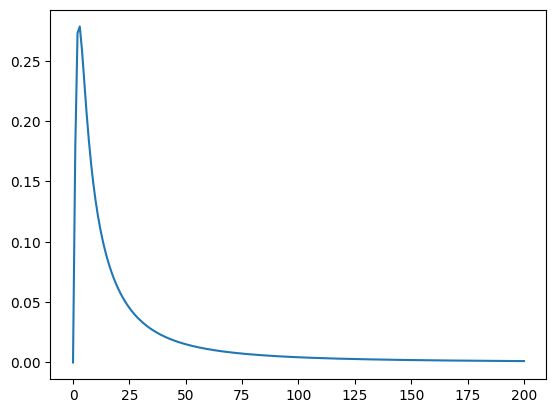

In [237]:
plt.plot(unitarity_scores)

In [238]:
unitarity_scores[-1]

0.001152862080530781

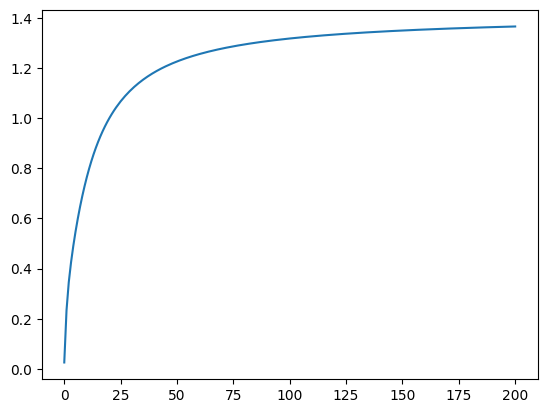

In [239]:
plt.plot(overlap_scores)

In [240]:
overlap_scores[-1]

1.3651409793555187

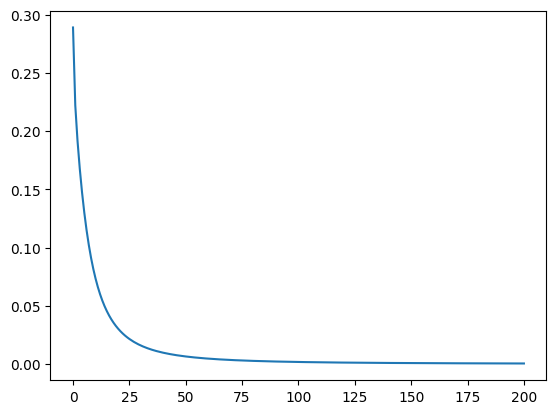

In [241]:
plt.plot(target_scores)

In [242]:
target_scores[-1]

0.00044768241664234836

# Analysis

## Learning rates

In [256]:
learning_rates = [0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

In [257]:
unitarity_scores = list()
overlap_scores = list()
target_scores = list()
matrix_dim = 2**6
target = np.sqrt(2)

num_iterations = 300

In [258]:
reduced_density_matrix = grouped_t
matrix = get_random_unitary_operator(grouped_t, matrix_dim)

In [260]:
for lr in learning_rates:
    unitarity_scores.append(list())
    overlap_scores.append(list())
    target_scores.append(list())

    current_matrix = matrix.copy()

    for _ in range(num_iterations):
        update(
            current_matrix,
            reduced_density_matrix,
            unitarity_scores[-1],
            overlap_scores[-1],
            target_scores[-1],
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label,
            matrix_dim,
            unitarity_lr=lr,
            overlap_lr=lr,
            target=target
        )

/tmp/ipykernel_6824/170727657.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


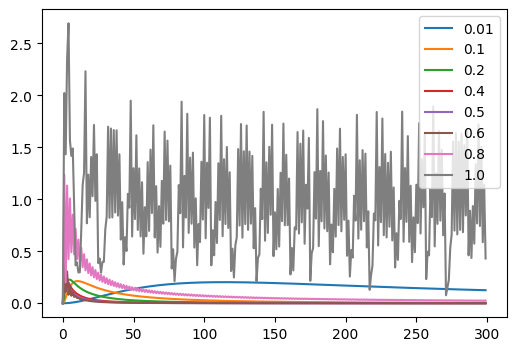

In [261]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(unitarity_scores, learning_rates):
    ax.plot(scores, label=label)

ax.legend()

fig.show()

In [262]:
np.array(unitarity_scores)[:,-1]

array([1.25600083e-01, 4.34358711e-03, 1.15593951e-03, 3.02697748e-04,
       1.97284505e-04, 1.39419761e-04, 2.62446647e-02, 4.30872543e-01])

Learning rate of 0.5-0.6 looks good. This agrees with the analytic calculations that a learning rate (for unitarity) of 0.5 is best.

/tmp/ipykernel_6824/3493712344.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


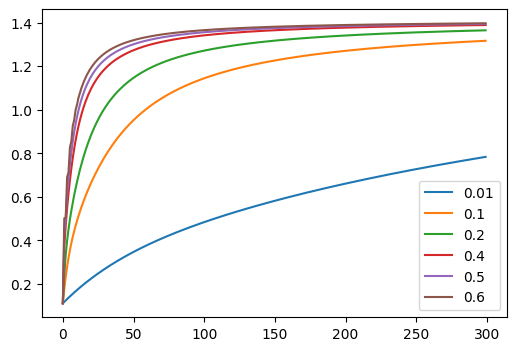

In [270]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(overlap_scores[:-2], learning_rates):
    ax.plot(scores, label=label)

ax.legend()

fig.show()

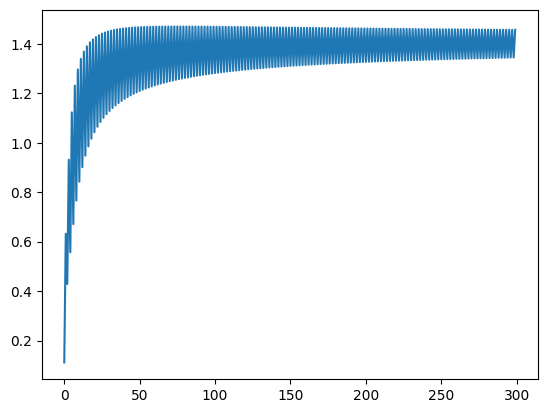

In [271]:
plt.plot(overlap_scores[-2])

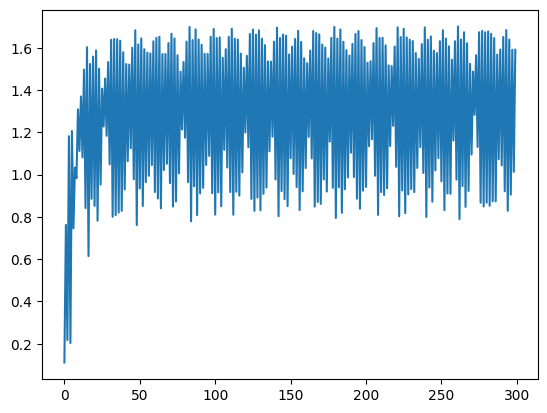

In [272]:
plt.plot(overlap_scores[-1])

In [268]:
np.array(overlap_scores)[:,-1]

array([0.78379179, 1.31693002, 1.36507357, 1.38933373, 1.39417037,
       1.39738803, 1.45627951, 1.59053154])

Similar story for the overlaps, but there's an additional oscillation for learning rate=0.8 not present in the unitarity scores. Unitarity gradient causing bouncing?

/tmp/ipykernel_6824/312821390.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


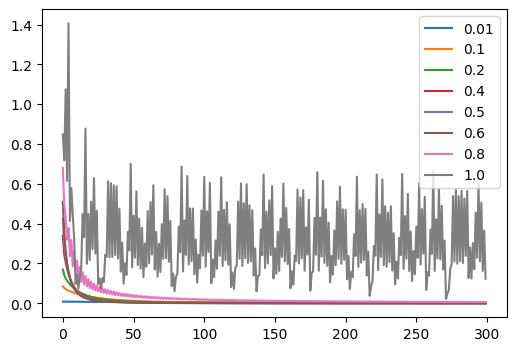

In [273]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(target_scores, learning_rates):
    ax.plot(scores, label=label)

ax.legend()

fig.show()

It doesn't make too much sense to compare target scores with different learning rates.

### Disparate Learning rates

In [278]:
learning_rates = [0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

In [279]:
unitarity_scores = list()
overlap_scores = list()
target_scores = list()
matrix_dim = 2**6
target = np.sqrt(2)

num_iterations = 150

In [280]:
reduced_density_matrix = grouped_t
matrix = get_random_unitary_operator(grouped_t, matrix_dim)

In [281]:
for unitarity_lr in learning_rates:
    unitarity_scores.append(list())
    overlap_scores.append(list())
    target_scores.append(list())

    for overlap_lr in learning_rates:
        unitarity_scores[-1].append(list())
        overlap_scores[-1].append(list())
        target_scores[-1].append(list())

        current_matrix = matrix.copy()
    
        for _ in range(num_iterations):
            update(
                current_matrix,
                reduced_density_matrix,
                unitarity_scores[-1][-1],
                overlap_scores[-1][-1],
                target_scores[-1][-1],
                grouped_physical_leg_label,
                grouped_physical_leg_conj_label,
                matrix_dim,
                unitarity_lr=unitarity_lr,
                overlap_lr=overlap_lr,
                target=target
            )

/tmp/ipykernel_6824/3438622814.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


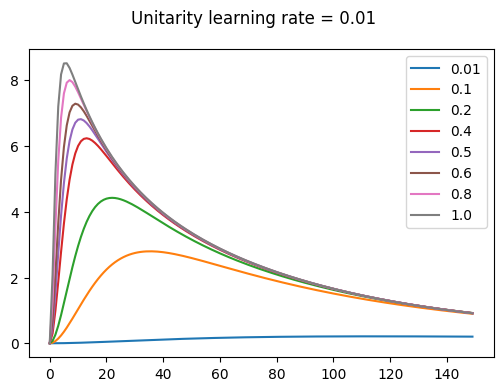

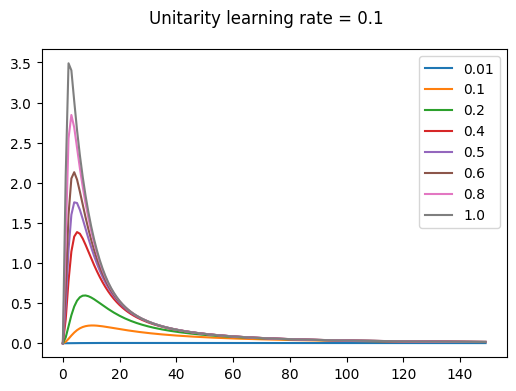

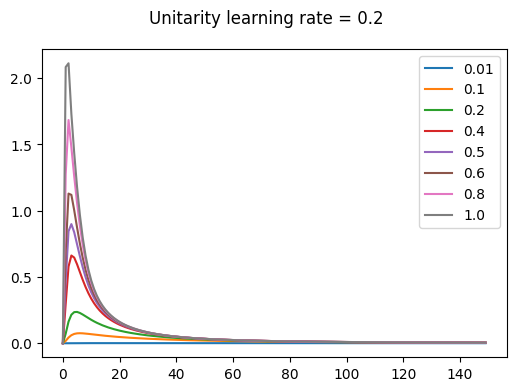

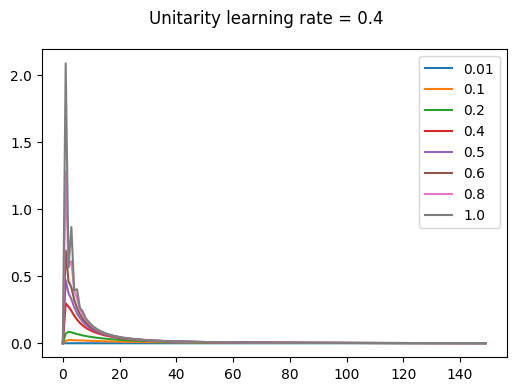

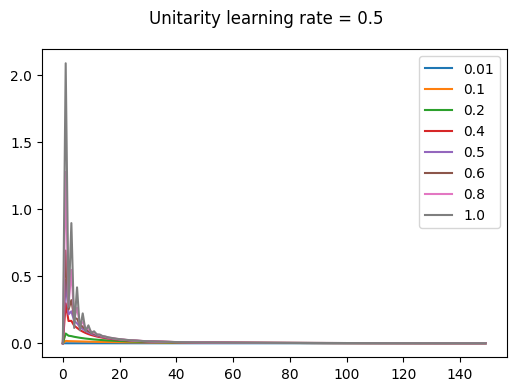

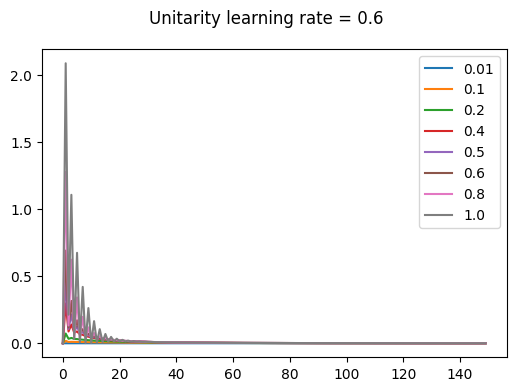

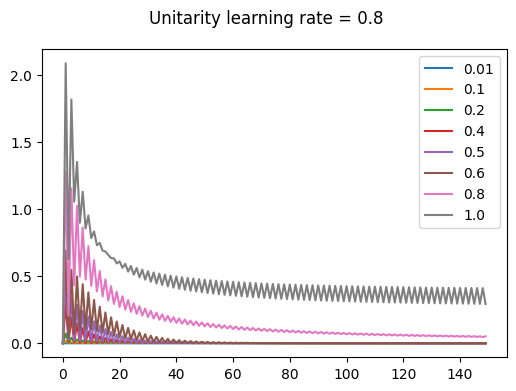

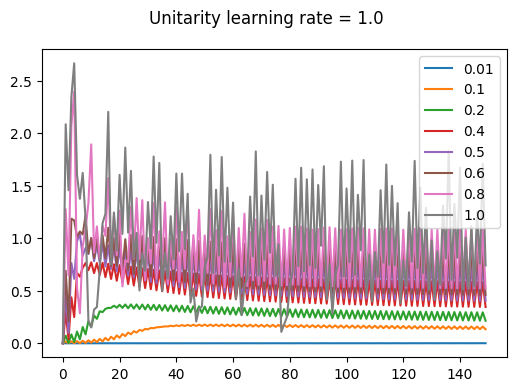

In [283]:
for scores_1, unitary_lr in zip(unitarity_scores, learning_rates):
    fig, ax = plt.subplots(figsize=(6, 4))

    for scores, overlap_lr in zip(scores_1, learning_rates):
        ax.plot(scores, label=overlap_lr)

    ax.legend()

    fig.suptitle(f"Unitarity learning rate = {unitary_lr}")
    fig.show()

/tmp/ipykernel_6824/1248678868.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


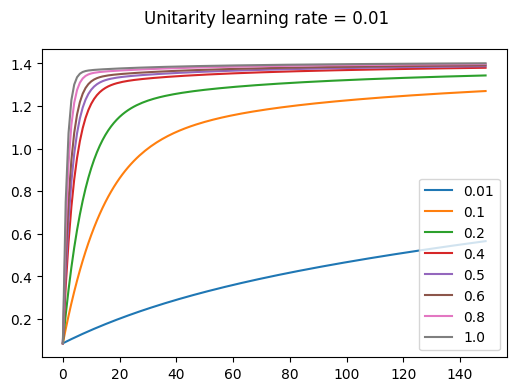

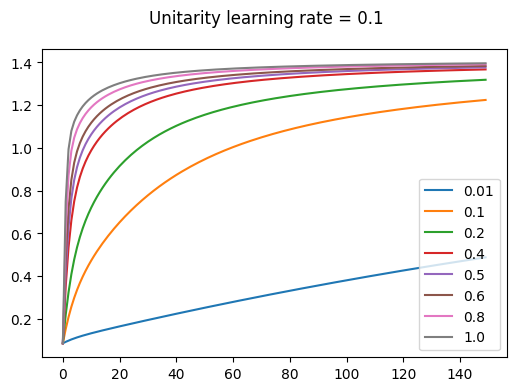

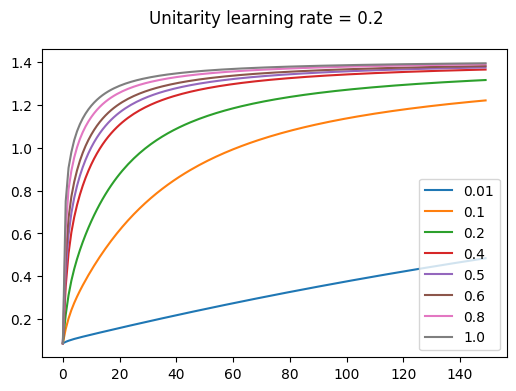

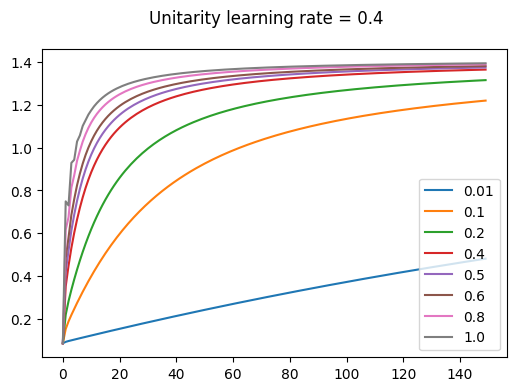

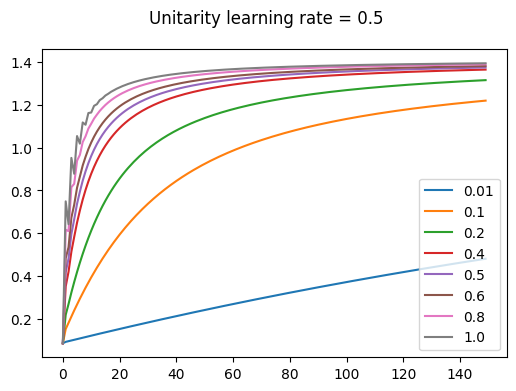

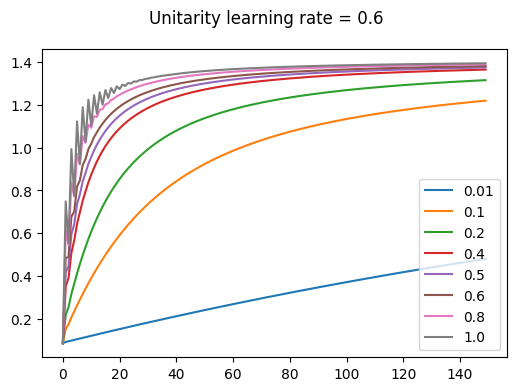

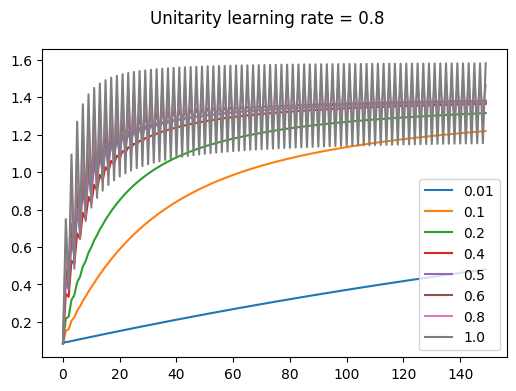

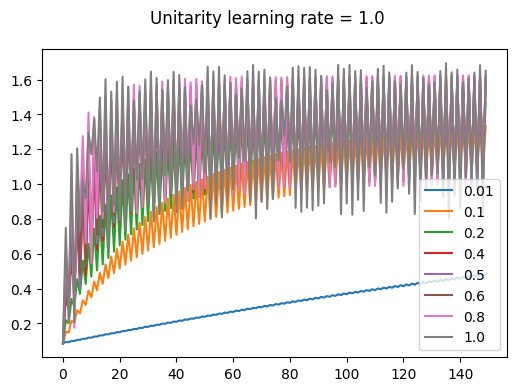

In [288]:
for scores_1, unitary_lr in zip(overlap_scores, learning_rates):
    fig, ax = plt.subplots(figsize=(6, 4))

    for scores, overlap_lr in zip(scores_1, learning_rates):
        ax.plot(scores, label=overlap_lr)

    ax.legend()

    fig.suptitle(f"Unitarity learning rate = {unitary_lr}")
    fig.show()

In [289]:
np.round(np.array(overlap_scores)[:,:, -1], 3)

array([[0.565, 1.27 , 1.343, 1.379, 1.387, 1.391, 1.397, 1.401],
       [0.488, 1.224, 1.319, 1.367, 1.377, 1.383, 1.391, 1.396],
       [0.483, 1.221, 1.317, 1.366, 1.376, 1.382, 1.39 , 1.395],
       [0.481, 1.22 , 1.316, 1.365, 1.375, 1.382, 1.39 , 1.395],
       [0.481, 1.22 , 1.316, 1.365, 1.375, 1.381, 1.39 , 1.395],
       [0.481, 1.22 , 1.316, 1.365, 1.375, 1.381, 1.39 , 1.394],
       [0.48 , 1.22 , 1.315, 1.365, 1.375, 1.381, 1.465, 1.582],
       [0.485, 1.334, 1.468, 1.568, 1.597, 1.619, 1.625, 1.65 ]])

/tmp/ipykernel_6824/3871090097.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


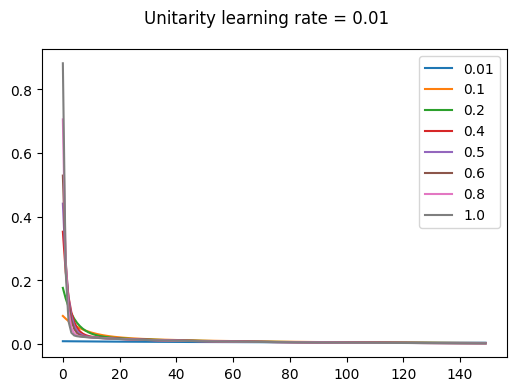

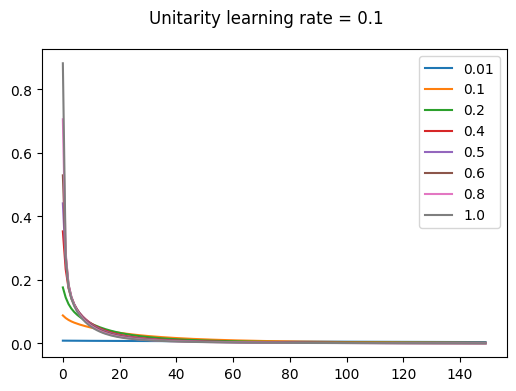

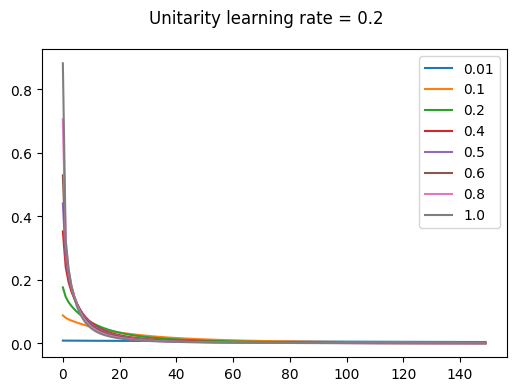

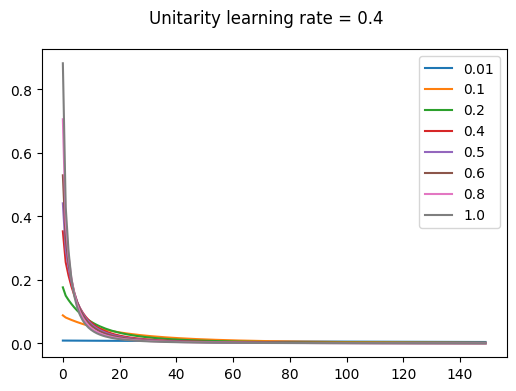

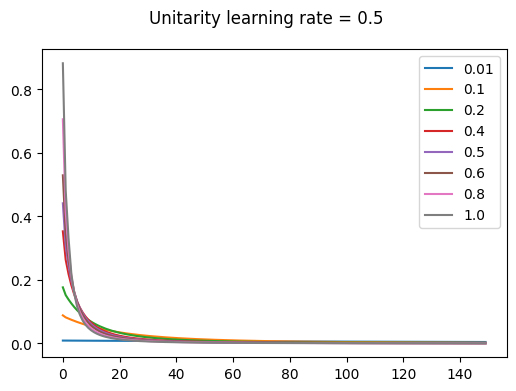

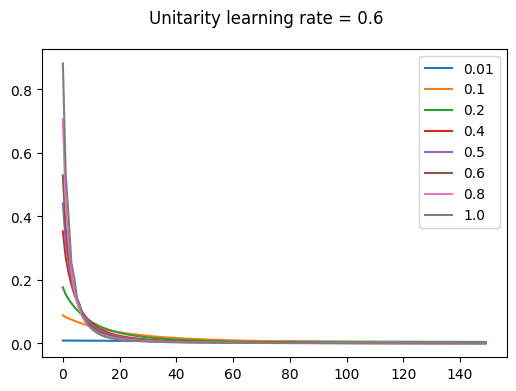

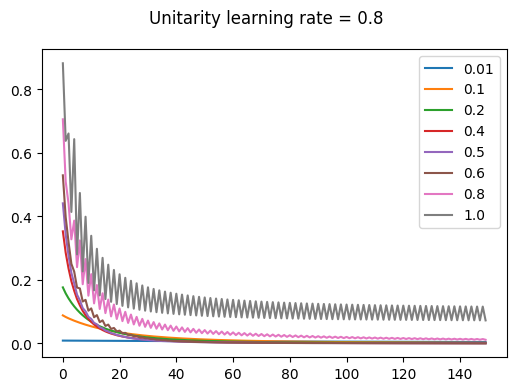

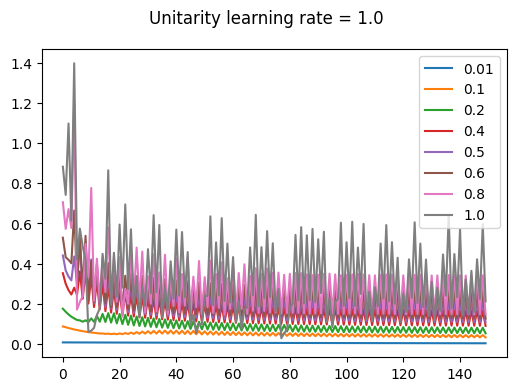

In [290]:
for scores_1, unitary_lr in zip(target_scores, learning_rates):
    fig, ax = plt.subplots(figsize=(6, 4))

    for scores, overlap_lr in zip(scores_1, learning_rates):
        ax.plot(scores, label=overlap_lr)

    ax.legend()

    fig.suptitle(f"Unitarity learning rate = {unitary_lr}")
    fig.show()

In [293]:
np.round(np.array(target_scores)[:,:, -1], 4)

array([[0.0041, 0.0033, 0.0028, 0.0025, 0.0025, 0.0024, 0.0024, 0.0024],
       [0.0044, 0.0022, 0.0013, 0.0009, 0.0008, 0.0007, 0.0006, 0.0006],
       [0.0044, 0.0021, 0.0012, 0.0007, 0.0006, 0.0005, 0.0005, 0.0004],
       [0.0044, 0.002 , 0.0011, 0.0006, 0.0005, 0.0004, 0.0004, 0.0003],
       [0.0044, 0.002 , 0.0011, 0.0006, 0.0005, 0.0004, 0.0003, 0.0003],
       [0.0044, 0.002 , 0.001 , 0.0006, 0.0005, 0.0004, 0.0003, 0.0003],
       [0.0044, 0.0019, 0.001 , 0.0005, 0.0004, 0.0004, 0.0114, 0.0725],
       [0.0045, 0.0337, 0.0539, 0.0911, 0.1092, 0.1275, 0.1482, 0.213 ]])

It doesn't make too much sense to compare target scores with different learning rates.

To-do:
* Analyse impact of learning rates
* Random initialization
* Increase number of sites, still feasable?
* Extract SPT phase, sweep over states (might be a separate notebook?)
    * Would need to account for symmetry transfer matrix singular value with sweep. May be better to just solve for left and right simultaneously?

# Conclusions

* Blah?

# Old code

## Test on scalars

In [77]:
scalar = 2*1j

In [78]:
scalar_rdm = npc.Array.from_ndarray_trivial(np.array([[scalar]]), labels=['p', 'p*'])

In [79]:
scalar_rdm

<npc.Array shape=(1, 1) labels=['p', 'p*']>

In [80]:
scalar_matrix = npc.Array.from_ndarray_trivial(np.array([[1.5]]), labels=['p', 'p*'])

In [81]:
unitarity_scores = list()
overlap_scores = list()
target_scores = list()
target = np.abs(scalar)
matrix_dim = 1
scalar_matrix_values = [scalar_matrix[0,0],]

In [82]:
unitarity_lr = 0.01
overlap_lr = 0.01

In [83]:
update(
    scalar_matrix,
    scalar_rdm,
    unitarity_scores,
    overlap_scores,
    target_scores,
    'p',
    'p*',
    matrix_dim,
    unitarity_lr=unitarity_lr,
    overlap_lr=overlap_lr,
    target=target
)

scalar_matrix_values.append(np.abs(scalar_matrix[0,0]))

In [84]:
unitarity_scores

[1.5625]

In [85]:
overlap_scores

[3.0]

In [86]:
for _ in range(100):
    update(
        scalar_matrix,
        scalar_rdm,
        unitarity_scores,
        overlap_scores,
        target_scores,
        'p',
        'p*',
        matrix_dim,
        unitarity_lr=unitarity_lr,
        overlap_lr=overlap_lr,
        target=target
    )

    scalar_matrix_values.append(np.abs(scalar_matrix[0,0]))

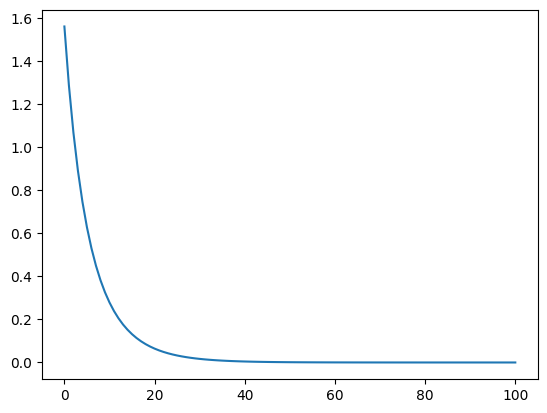

In [87]:
plt.plot(unitarity_scores)

In [88]:
unitarity_scores[-1]

2.5438619757345293e-06

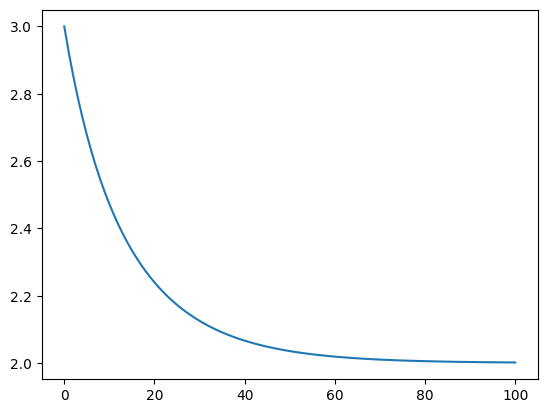

In [89]:
plt.plot(overlap_scores)

In [90]:
overlap_scores[-1]

2.001594313435545

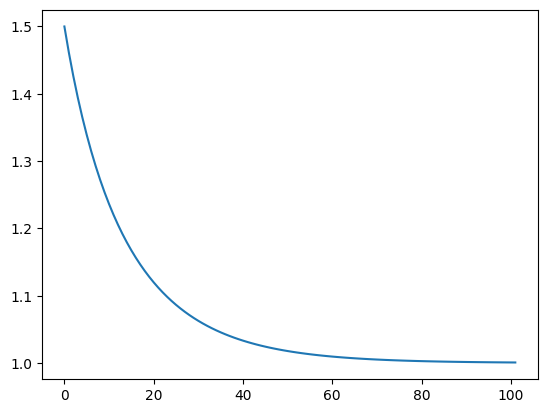

In [91]:
plt.plot(scalar_matrix_values)

In [92]:
scalar_matrix.to_ndarray()

array([[1.00074931+0.j]])

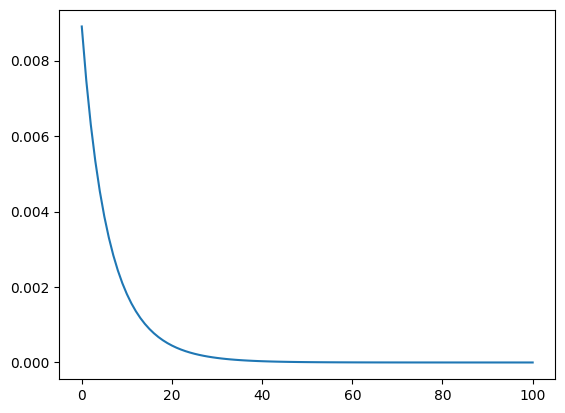

In [93]:
plt.plot(target_scores)